<a href="https://colab.research.google.com/github/cjkreienkamp/machine-learning-notebooks/blob/main/04_tabular_data_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set up environment

In [1]:
import sys
import cv2
import os

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torchsummary import summary

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [2]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# Data preparation

In [3]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_df = pd.read_csv(url, names=column_names,
                 na_values='?', comment='\t',
                 sep=' ', skipinitialspace=True)

In [6]:
df = raw_df.dropna()
df['Origin'] = df['Origin'].astype('category')
df['Origin'] = df['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 392 entries, 0 to 397
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   MPG           392 non-null    float64 
 1   Cylinders     392 non-null    int64   
 2   Displacement  392 non-null    float64 
 3   Horsepower    392 non-null    float64 
 4   Weight        392 non-null    float64 
 5   Acceleration  392 non-null    float64 
 6   Model Year    392 non-null    int64   
 7   Origin        392 non-null    category
dtypes: category(1), float64(5), int64(2)
memory usage: 25.0 KB


<ipython-input-6-2a3dd75373eb>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Origin'] = df['Origin'].astype('category')
<ipython-input-6-2a3dd75373eb>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Origin'] = df['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})


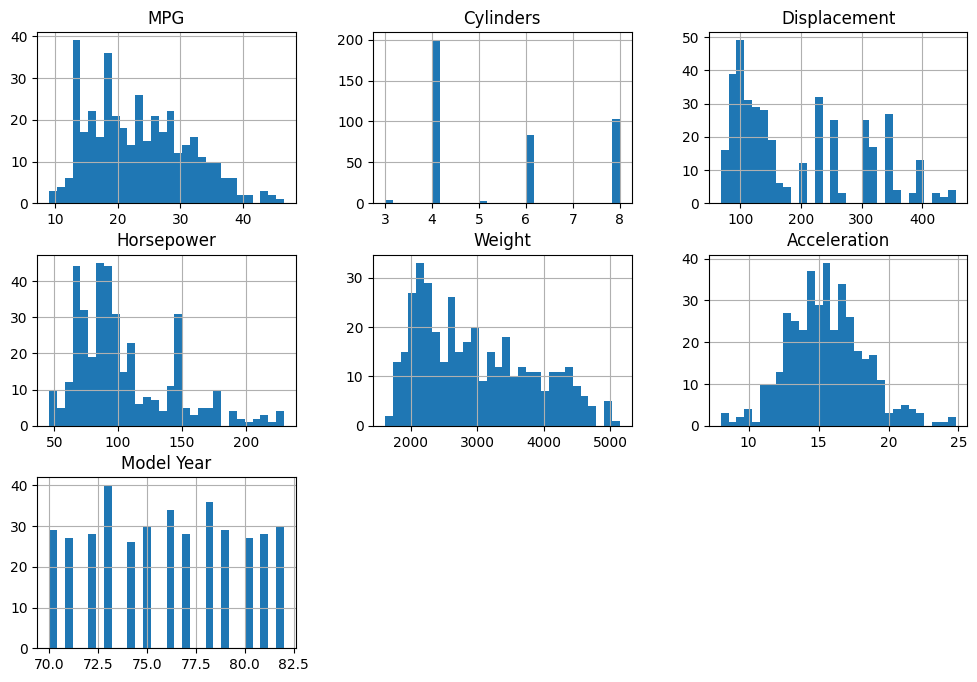

In [7]:
df.hist(figsize=(12,8), bins=30)
plt.show()

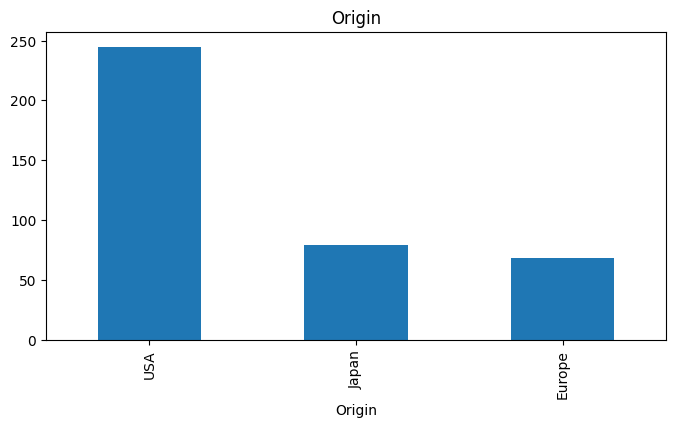

In [8]:
for col in df.select_dtypes(include=['category']):
    plt.figure(figsize=(8, 4))
    df[col].value_counts().plot(kind='bar')
    plt.title(col)
    plt.show()

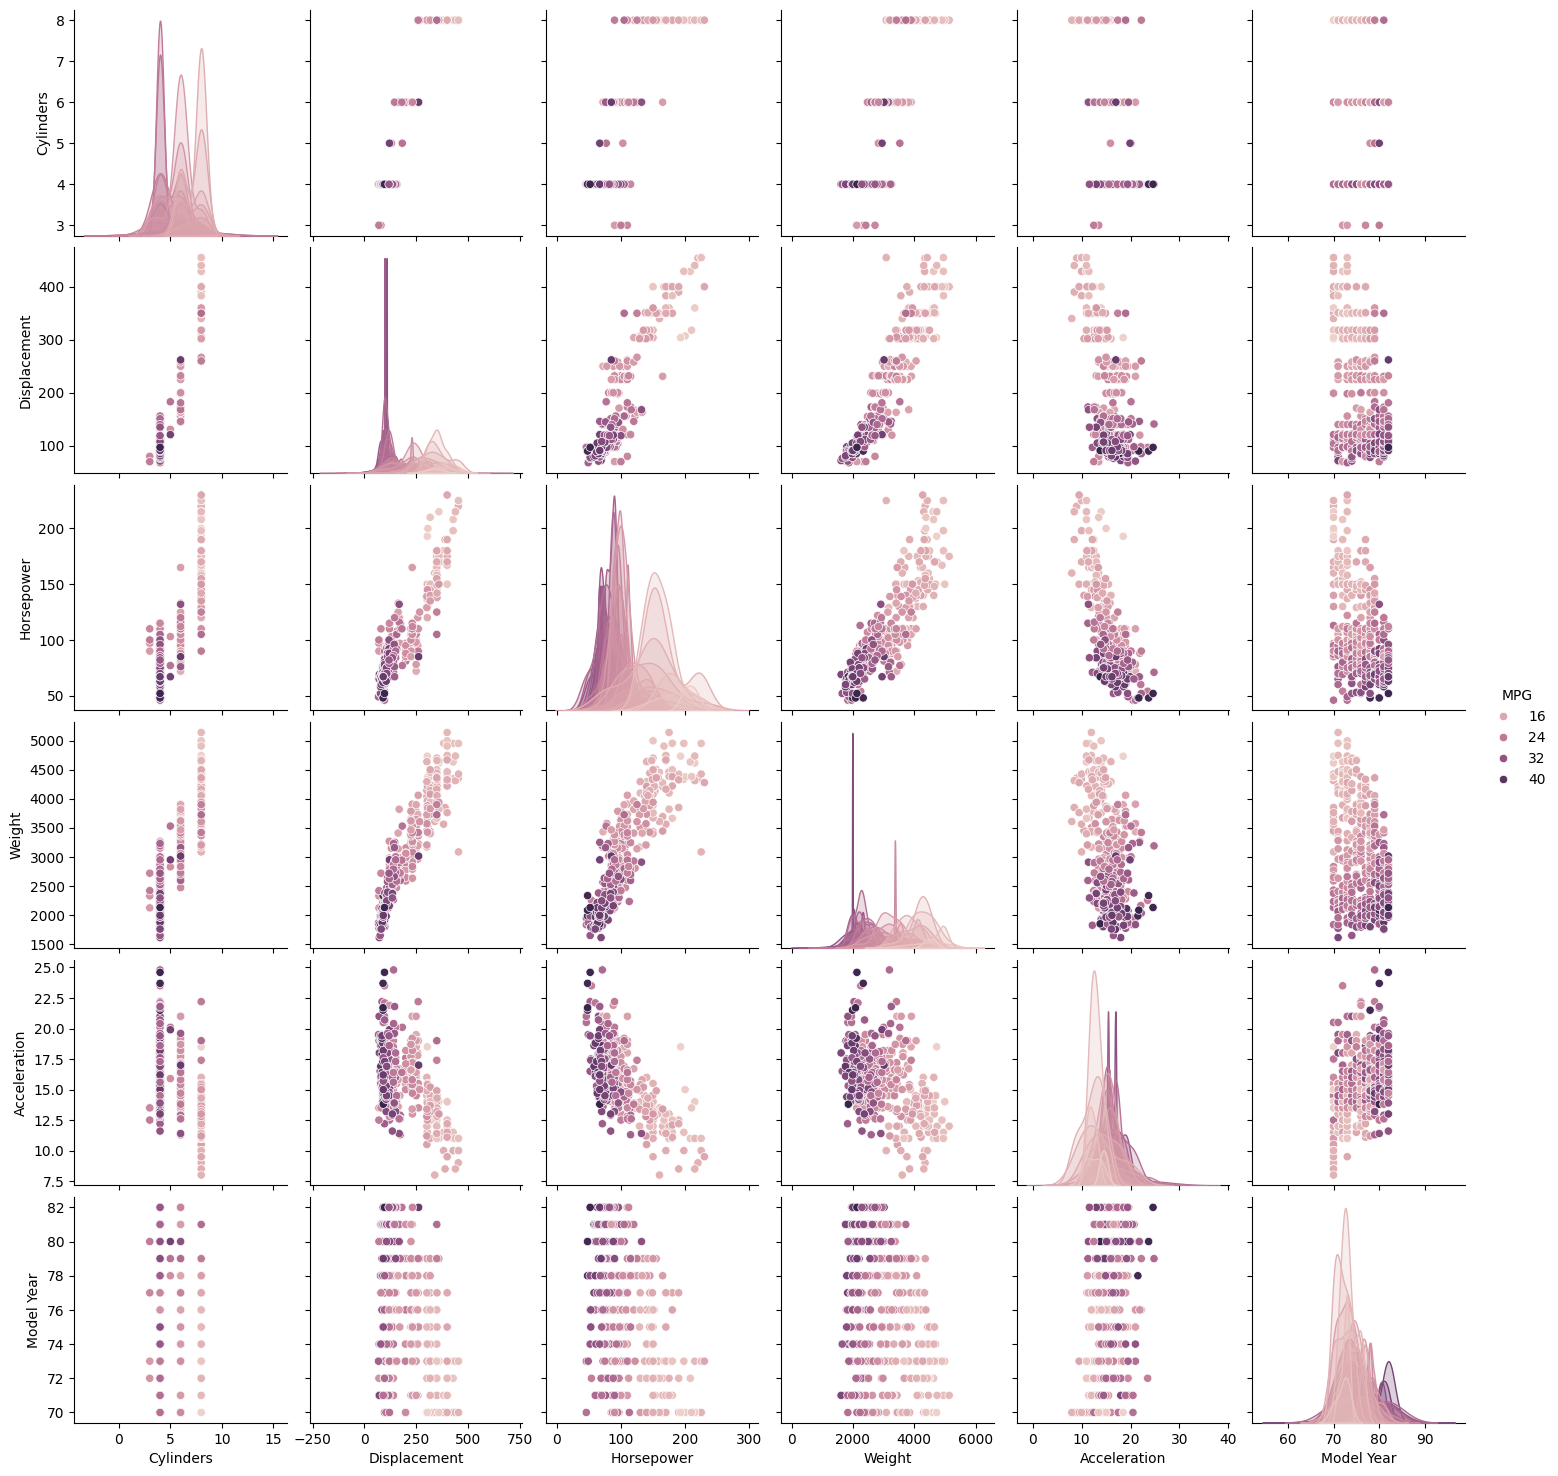

In [9]:
import seaborn as sns

sns.pairplot(df, hue='MPG')
plt.show()

In [10]:
train_df, temp_df  = train_test_split(df, test_size=0.20, shuffle=True)
valid_df, test_df = train_test_split(temp_df, test_size=0.50, shuffle=True)

In [11]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

class AutoMPGDataset(Dataset):
    def __init__(self, df):

        numeric_cols_zscore = ['Cylinders', 'Displacement', 'Horsepower', 'Weight', 'Acceleration', 'Model Year']
        low_cardinality_cats = ['Origin']
        target_col = ['MPG']

        df[numeric_cols_zscore] = pd.DataFrame(StandardScaler().fit_transform(df[numeric_cols_zscore]),
                                               index=df.index, columns=numeric_cols_zscore)

        df = pd.get_dummies(df, columns=low_cardinality_cats, drop_first=True)

        self.y = df[target_col].values.astype(np.float32)

        df = df.drop(target_col, axis=1)

        self.X = df.values.astype(np.float32)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, index):
        return torch.tensor(self.X[index]), torch.tensor(self.y[index])

In [12]:
train_dataset = AutoMPGDataset(train_df)
valid_dataset = AutoMPGDataset(valid_df)
test_dataset = AutoMPGDataset(test_df)

In [13]:
print(len(train_dataset))

313


In [22]:
train_dataset[np.random.randint(len(train_dataset))]

(tensor([-0.8581, -0.5342, -0.3236, -0.1521,  0.2967,  1.6544,  0.0000,  0.0000]),
 tensor([24.]))

# Model training 1


In [74]:
from xgboost import XGBRegressor

model = XGBRegressor(n_estimators=200, learning_rate=0.1, max_depth=6)
model.fit(train_dataset.X, train_dataset.y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [75]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_pred = model.predict(test_dataset.X)
y_test = test_dataset.y

mse = mean_squared_error(test_dataset.y, y_pred)
rmse = mse ** 0.5  # RMSE is just the square root of MSE
mae = mean_absolute_error(test_dataset.y, y_pred)
r2 = r2_score(test_dataset.y, y_pred)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² Score: {r2:.4f}")


Mean Squared Error (MSE): 22.0343
Root Mean Squared Error (RMSE): 4.6941
Mean Absolute Error (MAE): 3.4421
R² Score: 0.6938


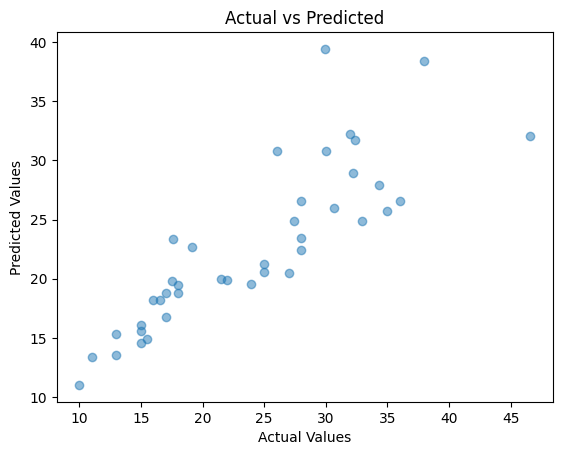

In [76]:
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted")
plt.show()

# Model training 2

In [23]:
torch.manual_seed(42)
BATCH_SIZE = 64
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [24]:
for x, y in train_loader:
    print(x.shape, y.shape)
    break

for x1, y1 in valid_loader:
    print(x1.shape, y1.shape)
    break

print(len(train_dataset), len(valid_dataset), len(test_dataset))

torch.Size([64, 8]) torch.Size([64, 1])
torch.Size([39, 8]) torch.Size([39, 1])
313 39 40


In [25]:
class AutoMPGNN(nn.Module):
    def __init__(self, input_size):
        super(AutoMPGNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

for x, y in train_loader:
    break
print(f"Input size: {x.shape}")
summary(AutoMPGNN(x.shape[1]), x.shape)

Input size: torch.Size([64, 8])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1              [-1, 64, 128]           1,152
            Linear-2               [-1, 64, 64]           8,256
            Linear-3                [-1, 64, 1]              65
Total params: 9,473
Trainable params: 9,473
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.09
Params size (MB): 0.04
Estimated Total Size (MB): 0.13
----------------------------------------------------------------


In [26]:
def train_fn(data_loader, model, optimizer):

    total_loss = 0.0

    model.train()

    for X, y in data_loader:

        X = X.to(DEVICE)
        y = y.to(DEVICE)

        predictions = model(X)

        loss = nn.MSELoss()(predictions, y)
        total_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return total_loss / len(data_loader)

def eval_fn(data_loader, model):

    total_loss = 0.0

    model.eval()

    with torch.inference_mode():

        for X, y in data_loader:

            X = X.to(DEVICE)
            y = y.to(DEVICE)

            predictions = model(X)

            loss = nn.MSELoss()(predictions, y)
            total_loss += loss.item()

        return total_loss / len(data_loader)

In [33]:
EPOCHS = 500
LEARNING_RATE = 0.001

In [34]:
torch.manual_seed(42)
model = AutoMPGNN(x.shape[1]).to(DEVICE)
optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

epoch_count, train_loss_values, valid_loss_values = [], [], []
train_acc_values, valid_acc_values = [], []
best_valid_loss = np.Inf

for epoch in range(EPOCHS):

    train_loss = train_fn(train_loader, model, optimizer)
    valid_loss = eval_fn(valid_loader, model)

    if valid_loss < best_valid_loss:
        torch.save(model.state_dict(), 'best_model.pth')
        best_valid_loss = valid_loss

    if epoch % int(EPOCHS / 10) == 0:
        print(f"Epoch: {epoch:4.0f} | Train Loss: {train_loss:.5f} | Validation Loss: {valid_loss:.5f}")
        epoch_count.append(epoch)
        train_loss_values.append(train_loss)
        valid_loss_values.append(valid_loss)


Epoch:    0 | Train Loss: 605.07013 | Validation Loss: 680.77203
Epoch:   50 | Train Loss: 12.25576 | Validation Loss: 15.84811
Epoch:  100 | Train Loss: 7.70136 | Validation Loss: 12.74192
Epoch:  150 | Train Loss: 6.58847 | Validation Loss: 11.89796
Epoch:  200 | Train Loss: 5.95788 | Validation Loss: 12.05347
Epoch:  250 | Train Loss: 5.54880 | Validation Loss: 11.78961
Epoch:  300 | Train Loss: 5.05988 | Validation Loss: 11.72082
Epoch:  350 | Train Loss: 4.72604 | Validation Loss: 12.05661
Epoch:  400 | Train Loss: 4.50968 | Validation Loss: 12.26761
Epoch:  450 | Train Loss: 4.25690 | Validation Loss: 12.43327


# Model evaluation

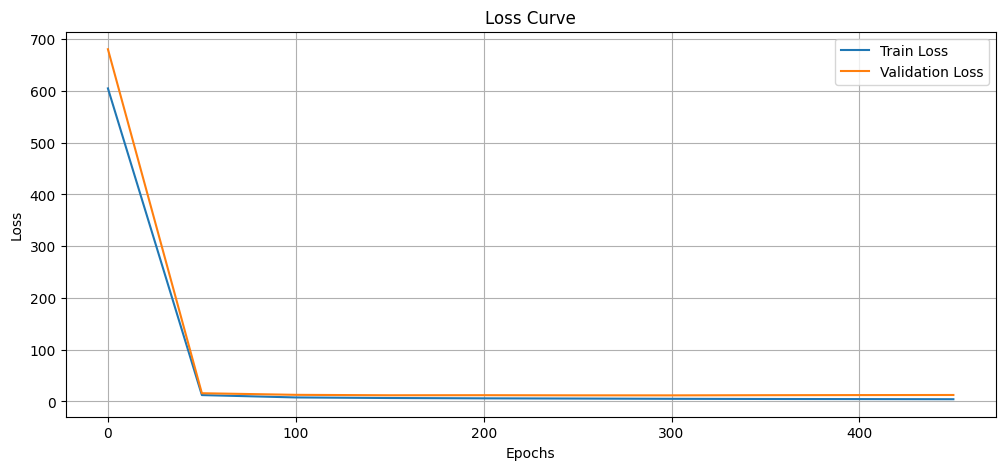

In [35]:
import matplotlib.pyplot as plt

def plot_loss(epoch_count, train_loss_values, valid_loss_values):
    fig, ax = plt.subplots(1, 1, figsize=(12, 5))

    # Plot Loss Curve
    ax.plot(epoch_count, train_loss_values, label='Train Loss')
    ax.plot(epoch_count, valid_loss_values, label='Validation Loss')
    ax.set_title('Loss Curve')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.legend()
    ax.grid(True)

    plt.show()

# Example Usage
plot_loss(epoch_count, train_loss_values, valid_loss_values)

In [36]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_pred = model(torch.tensor(test_dataset.X).to(DEVICE)).cpu().detach().numpy()
y_test = test_dataset.y

mse = mean_squared_error(test_dataset.y, y_pred)
rmse = mse ** 0.5  # RMSE is just the square root of MSE
mae = mean_absolute_error(test_dataset.y, y_pred)
r2 = r2_score(test_dataset.y, y_pred)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² Score: {r2:.4f}")

Mean Squared Error (MSE): 5.4119
Root Mean Squared Error (RMSE): 2.3264
Mean Absolute Error (MAE): 1.6411
R² Score: 0.9080


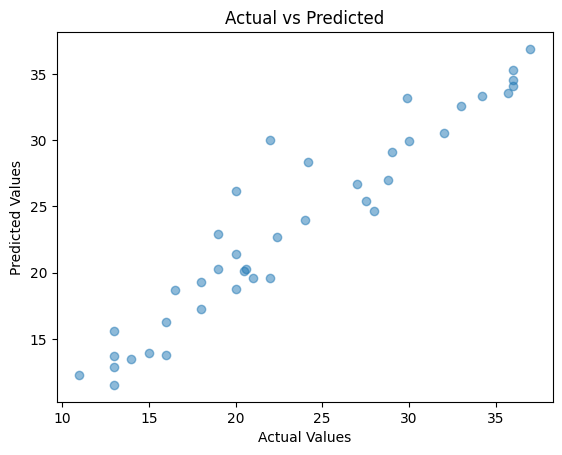

In [37]:
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted")
plt.show()